In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the dataset
data = pd.read_csv('top_50_stocks_data_formatted.csv')

In [5]:
# Calculating annualized return
data['Daily Return'] = data.groupby('Ticker')['Adjusted Close'].pct_change()
annualized_return = data.groupby('Ticker')['Daily Return'].mean() * 252

# Calculating annualized volatility
annualized_volatility = data.groupby('Ticker')['Daily Return'].std() * (252 ** 0.5)

# Assuming there's risk-free rate of 0.01 (1%)
risk_free_rate = 0.01

# Calculating Sharpe ratio
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Create a dataframe to hold these metrics
metrics = pd.DataFrame({
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_volatility,
    'Sharpe Ratio': sharpe_ratio
})
# Display the first 5 rows of annualized return, annualized volatility, and Sharpe ratio
metrics.head(5)

,Annualized Return,Annualized Volatility,Sharpe Ratio
Ticker,,,
AAPL,0.104308,0.282416,0.333933
ABBV,0.155988,0.206717,0.706222
ABT,-0.073977,0.223648,-0.375486
ACN,-0.065795,0.276094,-0.274526
ADBE,0.071310,0.392165,0.156337


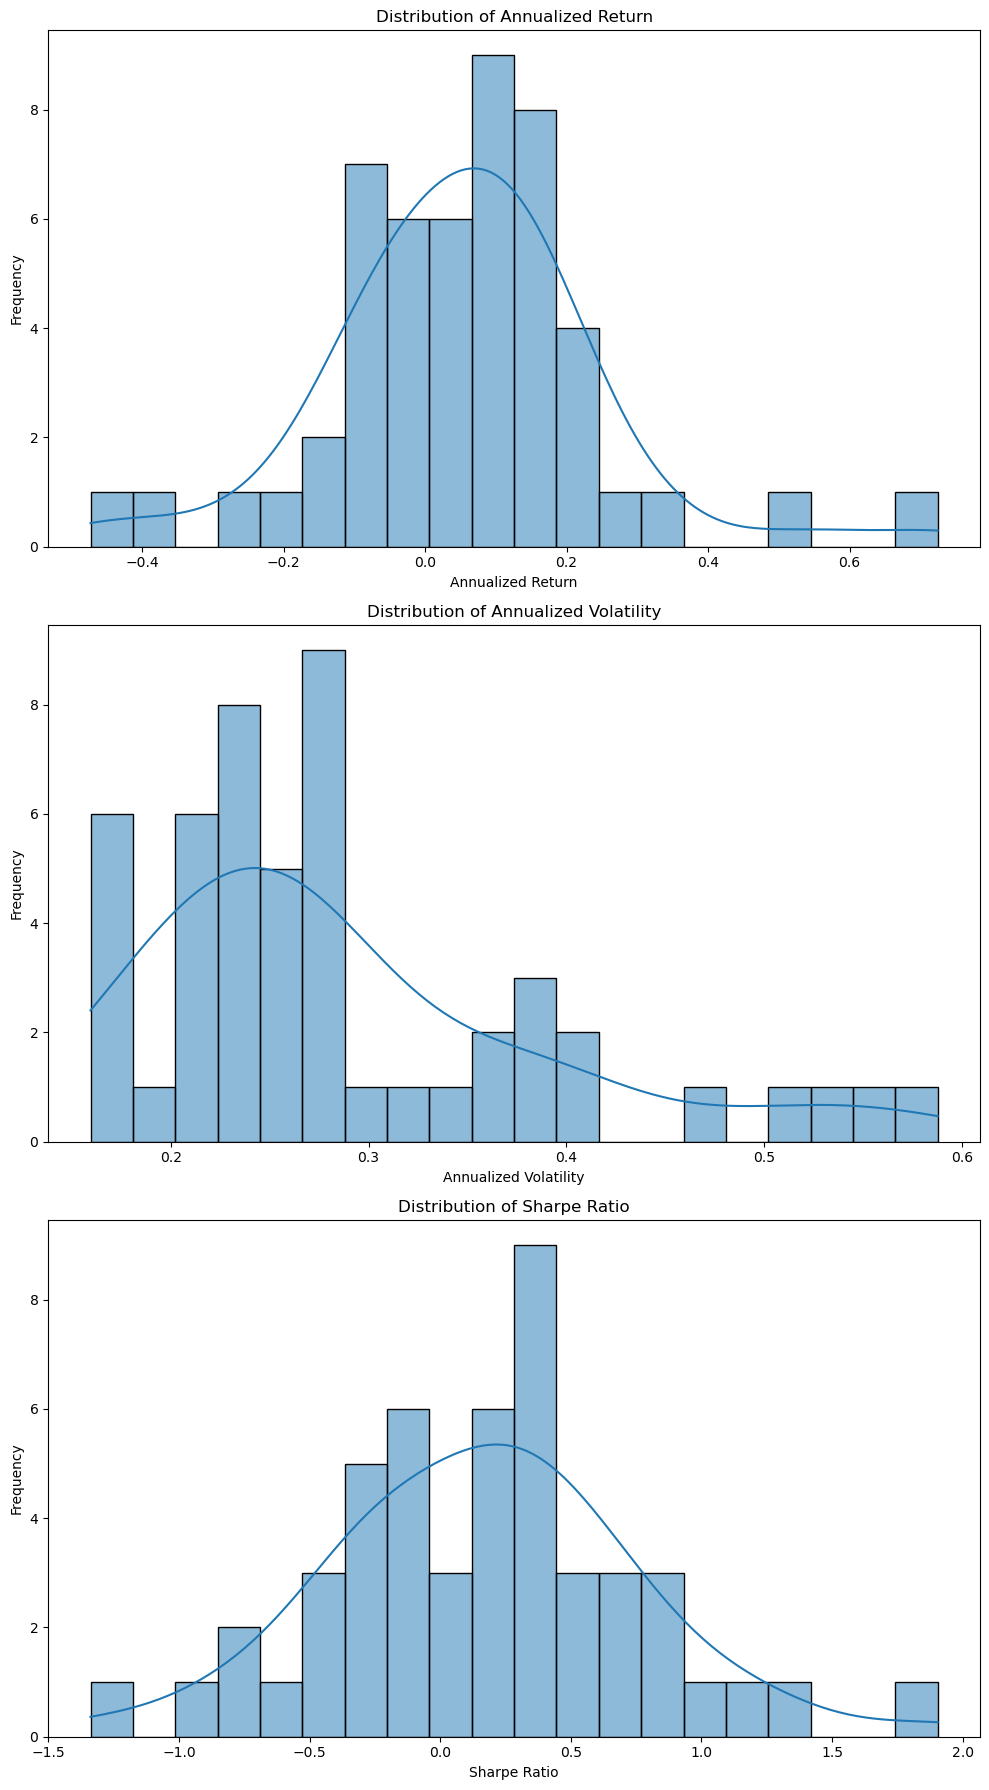

In [6]:
# Set up the figure and axes for the plots
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Plot histograms for each metric
sns.histplot(metrics['Annualized Return'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Annualized Return')
axes[0].set_xlabel('Annualized Return')
axes[0].set_ylabel('Frequency')

sns.histplot(metrics['Annualized Volatility'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Annualized Volatility')
axes[1].set_xlabel('Annualized Volatility')
axes[1].set_ylabel('Frequency')

sns.histplot(metrics['Sharpe Ratio'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Sharpe Ratio')
axes[2].set_xlabel('Sharpe Ratio')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

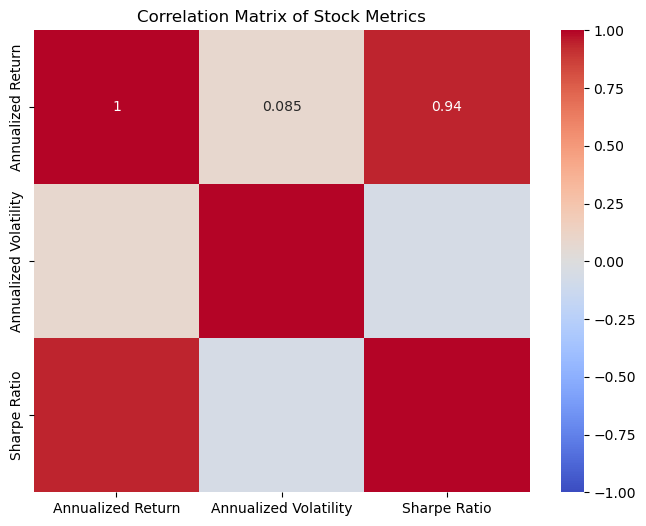

In [8]:
# Calculate and visualize the correlation matrix
correlation_matrix = metrics.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Stock Metrics')
plt.show()

In [26]:
# Calculating Q1 (25th percentile) and Q3 (75th percentile) for numerical columns
Q1 = data[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']].quantile(0.25)
Q3 = data[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']].quantile(0.75)

# Calculating IQR for each column
IQR = Q3 - Q1

# Defining bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping outliers by replacing them with the nearest valid value within the bounds
data_capped = data.copy()
data_capped[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']] = data_capped[['Open', 'Close', 'High', 'Low', 'Adjusted Close', 'Volume']].clip(lower=lower_bound, upper=upper_bound, axis=1)

Enter the company's abbreviated names separated by commas (e.g., AAPL,GOOGL,MSFT): AAPL
Enter the start date YYYY-MM-DD: 2021-03-20
Enter the end date YYYY-MM-DD: 2022-03-20


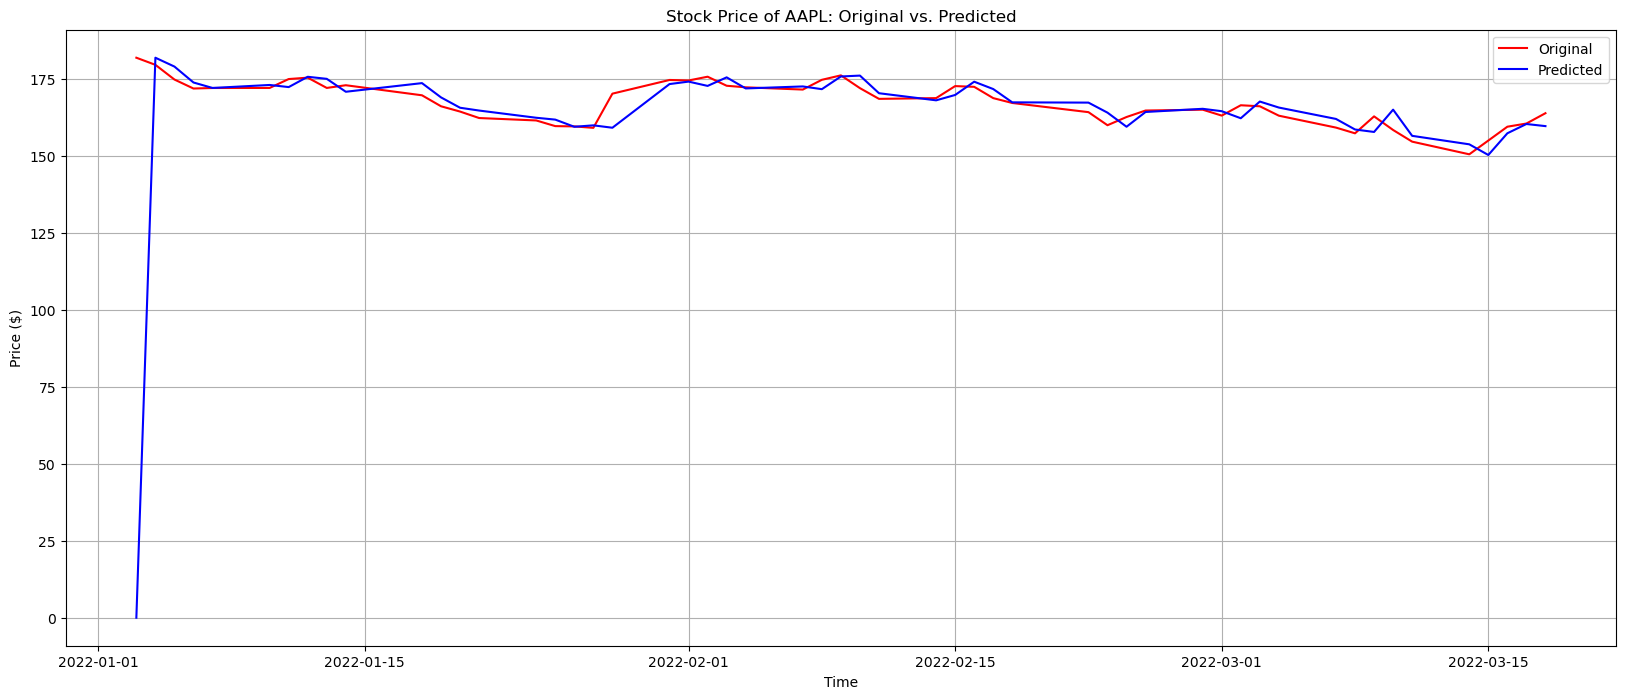

MAPE for AAPL: 3.28%


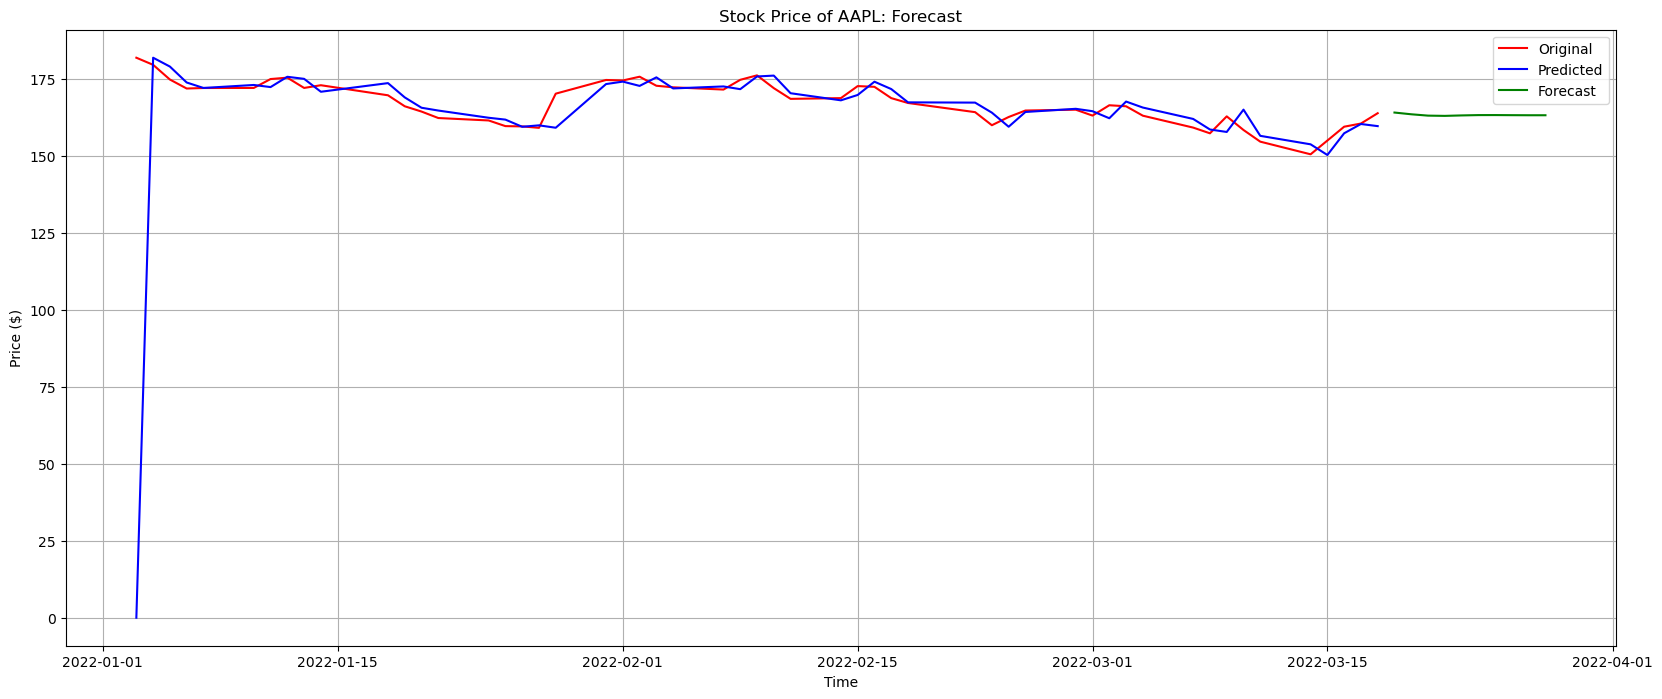

AAPL forecast:
 2022-03-19    164.191584
2022-03-20    163.628433
2022-03-21    163.190565
2022-03-22    163.109063
2022-03-23    163.257098
2022-03-24    163.361646
2022-03-25    163.371585
2022-03-26    163.338553
2022-03-27    163.315048
2022-03-28    163.313786
Freq: D, dtype: float64


In [ ]:
# Function to calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Defining a dictionary to store filtered DataFrames
company_data = {}

# List of company names
company_names = data['Ticker'].unique()

# Filtering data for each company and store in the dictionary
for company in company_names:
    company_data[company] = data[data['Ticker'] == company]

# Function to analyze multiple stocks and collect feedback
def analyze_multiple_stocks(companies, start_date, end_date):
    feedback = {}
    for company in companies:
        stock_data = company_data[company]
        stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]
        
        # Ensure 'Date' is in datetime format and set it as index
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        stock_data.set_index('Date', inplace=True)
        
        # Finding closing prices
        closing_prices = stock_data['Close']
        
        # Fitting the ARIMA model for company's stock
        model = ARIMA(closing_prices, order=(5,1,0))
        model_fit = model.fit()
        
        # Making predictions for company's stock
        predictions = model_fit.predict(start=0, end=len(closing_prices)-1, typ='levels')
        predictions.index = closing_prices.index  # Align predictions with the original dates
        
        # Plot the original and predicted closing prices
        plt.figure(figsize=(20,8))
        plt.plot(closing_prices, color='red', label='Original')
        plt.plot(predictions, color='blue', label='Predicted')
        plt.title(f'Stock Price of {company}: Original vs. Predicted')
        plt.xlabel('Time')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Checking error percentage
        mape_company = mean_absolute_percentage_error(closing_prices, predictions)
        print(f"MAPE for {company}: {mape_company:.2f}%")
        
        # Forecasting future values
        forecast_steps = 10
        forecast = model_fit.get_forecast(steps=forecast_steps)
        forecast_index = pd.date_range(start=closing_prices.index[-1], periods=forecast_steps+1, freq='D')[1:]
        forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
        
        # Plot forecasted values
        plt.figure(figsize=(20,8))
        plt.plot(closing_prices, color='red', label='Original')
        plt.plot(predictions, color='blue', label='Predicted')
        plt.plot(forecast_series, color='green', label='Forecast')
        plt.title(f'Stock Price of {company}: Forecast')
        plt.xlabel('Time')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        print(f"{company} forecast:\n", forecast_series)

        # Collecting user feedback
        rating = input(f"After Use Please rate the accuracy of the prediction for {company} (1-5): ")
        improvement = input(f"Please provide any suggestions for improving the prediction for {company}: ")
        feedback[company] = {'rating': rating, 'improvement': improvement}

    return feedback

# Taking user input for multiple companies, start date, and end date
companies = input("Enter the company's abbreviated names separated by commas (e.g., AAPL,GOOGL,MSFT):").split(',')
start_date = input("Enter the start date YYYY-MM-DD:")
end_date = input("Enter the end date YYYY-MM-DD:")

# Analyzing multiple stocks and collecting feedback
feedback = analyze_multiple_stocks(companies, start_date, end_date)

# Display collected feedback
print("Collected Feedback:")
for company, fb in feedback.items():
    print(f"{company} - Rating: {fb['rating']}, Improvement Suggestions: {fb['improvement']}")

In [ ]:
#Asking for user's risk level
risk_level = input("Enter your risk level (low, medium, high):").lower()

# Making a recommendation based on the user's risk level and stock's volatility
volatility_threshold = {'low': 0.2, 'medium': 0.5, 'high': 1.0}
stock_volatility = annualized_volatility[company]

if stock_volatility > volatility_threshold[risk_level]:
    recommendation = "not to buy" if risk_level != "high" else "to buy with caution"
else:
    recommendation = "to buy"

print(f"Based on your risk level and the stock's volatility, it is recommended {recommendation} the stock {company}.")